<a href="https://colab.research.google.com/github/prernac-dotcom/image_processing/blob/main/Image_restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Image restoration

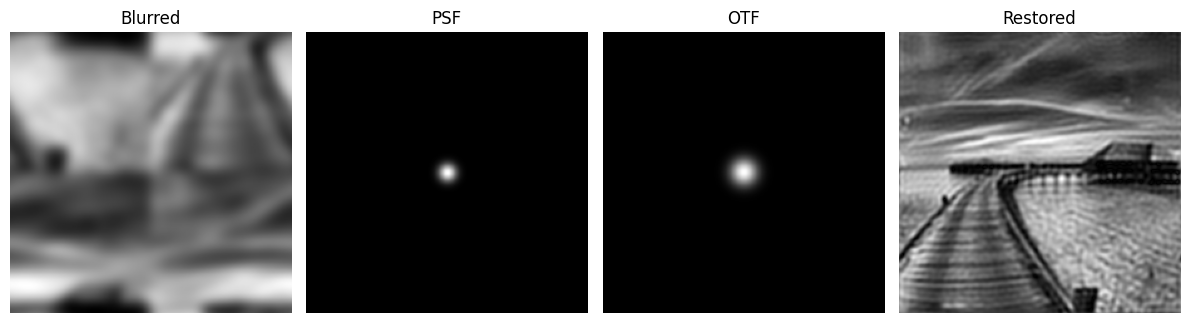

In [ ]:
# Generate a Gaussian-blurred image using frequency domain filtering and restore using inverse filtering.
import cv2, numpy as np, matplotlib.pyplot as plt

A = cv2.imread('2.jpg', cv2.IMREAD_GRAYSCALE)
x, y = A.shape
X, Y = np.meshgrid(np.arange(y), np.arange(x))
h = np.exp(-((X - y/2)**2 + (Y - x/2)**2) / 48)

H = np.fft.fftshift(np.fft.fft2(h, s=A.shape))
FA = np.fft.fftshift(np.fft.fft2(A))
g = np.abs(np.fft.ifft2(np.fft.ifftshift(FA * H)))

G = np.fft.fftshift(np.fft.fft2(g))
F = np.zeros_like(G, dtype=np.complex128)
mask = np.abs(H) > 1e-6
F[mask] = G[mask] / H[mask]
f = np.abs(np.fft.ifft2(np.fft.ifftshift(F)))

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1); plt.imshow(g, cmap='gray'); plt.title('Blurred'); plt.axis('off')
plt.subplot(1, 4, 2); plt.imshow(h, cmap='gray'); plt.title('PSF'); plt.axis('off')
plt.subplot(1, 4, 3); plt.imshow(np.abs(H), cmap='gray'); plt.title('OTF'); plt.axis('off')
plt.subplot(1, 4, 4); plt.imshow(f, cmap='gray'); plt.title('Restored'); plt.axis('off')
plt.tight_layout(); plt.show()


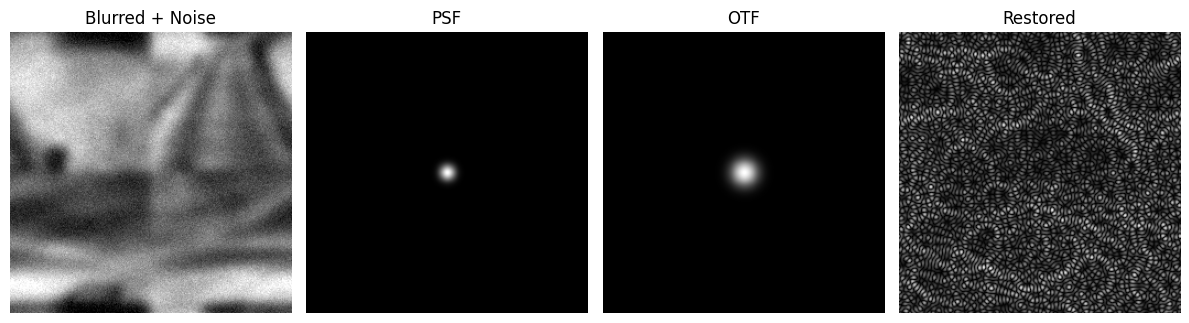

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise

# Applies Gaussian blur in frequency domain, adds Gaussian noise, then restores image using inverse filtering.
A = cv2.imread('2.jpg', cv2.IMREAD_GRAYSCALE)
A = cv2.resize(A, (256, 256))
x, y = A.shape
X, Y = np.meshgrid(np.arange(y), np.arange(x))
h = np.exp(-((X - y/2)**2 + (Y - x/2)**2) / 48)
h = h / np.sum(h)

H = np.fft.fftshift(np.fft.fft2(h, s=A.shape))
FA = np.fft.fftshift(np.fft.fft2(A))
g = np.abs(np.fft.ifft2(np.fft.ifftshift(FA * H)))
g = (g - g.min()) / (g.max() - g.min())
g_noisy = random_noise(g, mode='gaussian', mean=0, var=0.002)

G = np.fft.fftshift(np.fft.fft2(g_noisy))
F = np.zeros_like(G, dtype=np.complex128)
mask = np.abs(H) > 1e-6
F[mask] = G[mask] / H[mask]
f = np.abs(np.fft.ifft2(np.fft.ifftshift(F)))

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1); plt.imshow(g_noisy, cmap='gray'); plt.title('Blurred + Noise'); plt.axis('off')
plt.subplot(1, 4, 2); plt.imshow(h, cmap='gray'); plt.title('PSF'); plt.axis('off')
plt.subplot(1, 4, 3); plt.imshow(np.abs(H), cmap='gray'); plt.title('OTF'); plt.axis('off')
plt.subplot(1, 4, 4); plt.imshow(f, cmap='gray'); plt.title('Restored'); plt.axis('off')
plt.tight_layout(); plt.show()


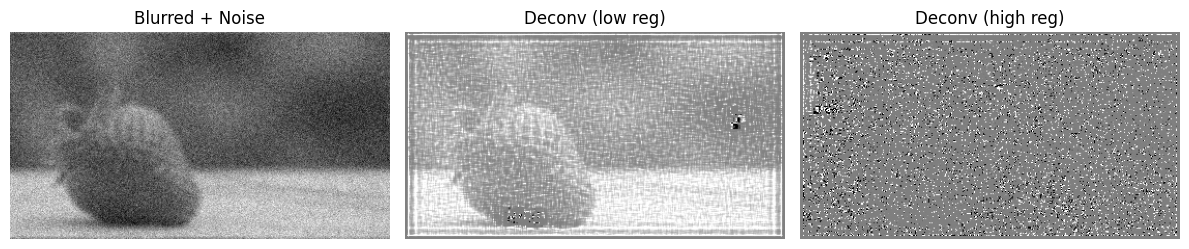

In [ ]:
# Example 6.4 – Constrained deconvolution using Gaussian PSF and regularization

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import richardson_lucy
from scipy.signal import convolve2d

I = cv2.imread('1.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0
psf_size, psf_sigma = 7, 10
x = np.linspace(-psf_size // 2, psf_size // 2, psf_size)
y = np.linspace(-psf_size // 2, psf_size // 2, psf_size)
X, Y = np.meshgrid(x, y)
psf = np.exp(-(X**2 + Y**2) / (2 * psf_sigma**2))
psf /= psf.sum()

V = 0.01
blurred = convolve2d(I, psf, mode='same', boundary='wrap')
blurred_noisy = blurred + np.random.normal(0, np.sqrt(V), I.shape)

J = richardson_lucy(blurred_noisy, psf, num_iter=30)
K = richardson_lucy(blurred_noisy, psf, num_iter=300)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1), plt.imshow(blurred_noisy, cmap='gray'), plt.title('Blurred + Noise'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(J, cmap='gray'), plt.title('Deconv (low reg)'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(K, cmap='gray'), plt.title('Deconv (high reg)'), plt.axis('off')
plt.tight_layout()
plt.show()


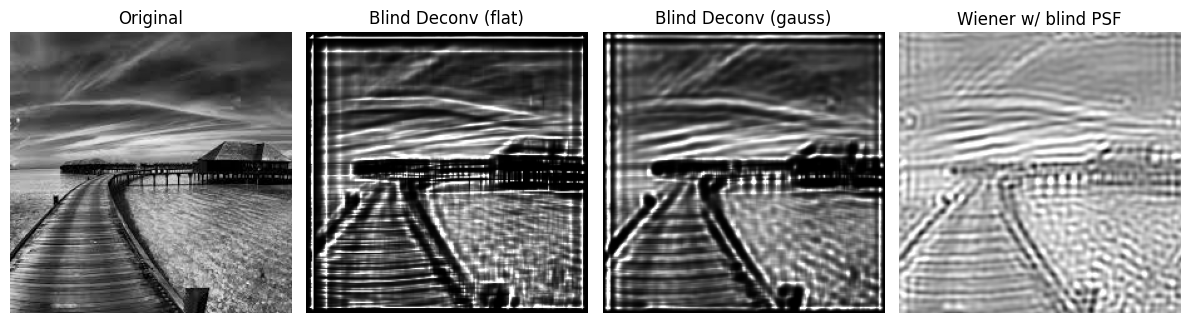

In [ ]:
#Blind deconvolution and Wiener filtering with initial PSF guesses

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import richardson_lucy, wiener
from scipy.signal import convolve2d

A = cv2.imread('2.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0
psf_init_flat = np.ones((10, 10))
psf_init_flat /= psf_init_flat.sum()
psf_gauss = cv2.getGaussianKernel(10, 3)
psf_gauss = psf_gauss @ psf_gauss.T
psf_gauss /= psf_gauss.sum()

J1 = richardson_lucy(A, psf_init_flat, num_iter=30)
J2 = richardson_lucy(A, psf_gauss, num_iter=30)
J3 = wiener(A, psf_gauss, balance=0.01)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1), plt.imshow(A, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(1, 4, 2), plt.imshow(J1, cmap='gray'), plt.title('Blind Deconv (flat)'), plt.axis('off')
plt.subplot(1, 4, 3), plt.imshow(J2, cmap='gray'), plt.title('Blind Deconv (gauss)'), plt.axis('off')
plt.subplot(1, 4, 4), plt.imshow(J3, cmap='gray'), plt.title('Wiener w/ blind PSF'), plt.axis('off')
plt.tight_layout()
plt.show()


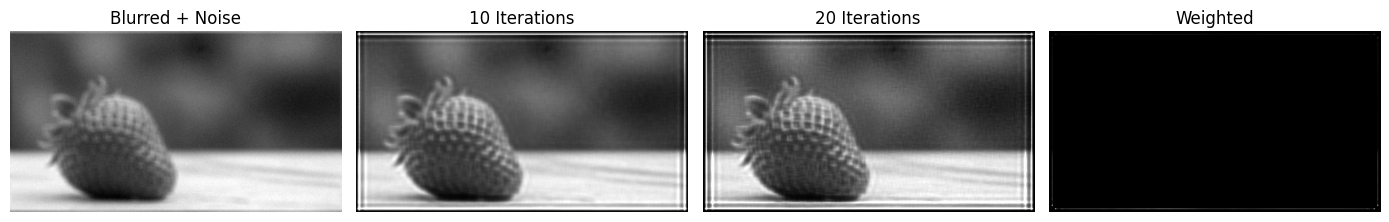

In [ ]:
#Lucy-Richardson deconvolution with noise and weighting

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import richardson_lucy
from scipy.signal import convolve2d

A = cv2.imread('1.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64)
A = (A - A.min()) / (A.max() - A.min())
psf = cv2.getGaussianKernel(7, 10)
psf = psf @ psf.T
psf /= psf.sum()
V = 0.0001

blurred = convolve2d(A, psf, mode='same', boundary='wrap')
J0 = blurred + np.random.normal(0, np.sqrt(V), A.shape)

WT = np.zeros_like(A)
WT[4:-4, 4:-4] = 1

J1 = richardson_lucy(J0, psf, num_iter=10)
J2 = richardson_lucy(J0, psf, num_iter=20)
J3 = richardson_lucy(J0 * WT, psf, num_iter=20) / (WT + 1e-8)

plt.figure(figsize=(14, 4))
plt.subplot(1, 4, 1), plt.imshow(J0, cmap='gray'), plt.title('Blurred + Noise'), plt.axis('off')
plt.subplot(1, 4, 2), plt.imshow(J1, cmap='gray'), plt.title('10 Iterations'), plt.axis('off')
plt.subplot(1, 4, 3), plt.imshow(J2, cmap='gray'), plt.title('20 Iterations'), plt.axis('off')
plt.subplot(1, 4, 4), plt.imshow(J3, cmap='gray'), plt.title('Weighted'), plt.axis('off')
plt.tight_layout()
plt.show()
